# Overview
This file documents the process of building the code necessary to take predictions from a trained `torch` neural network and format the results so that they may be stored in a container. At first the choice of container will be restricted to `pandas.Dataframe` only. 

## Load Model Dictionary

In [124]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [125]:
import torch


state_dict = r'../../model_dict/maskrcnn_resnet50_state_dict.pth'

model = get_instance_segmentation_model(2)
model.load_state_dict(torch.load(state_dict))

<All keys matched successfully>

In [126]:
device = torch.device('cuda')

In [127]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

## Download Imagery

In [9]:
import os
import errno
import json
import gdal
import numpy as np

from googleapiclient.http import MediaFileUpload

from google.cloud import storage
from skimage.io import imread

# Create the service client.
from googleapiclient.discovery import build
from apiclient.http import MediaIoBaseDownload

In [13]:
# GOOGLE CREDS is different for notebook – change for .py files
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
GEO_FILTER_PATH = os.getenv('GEO_FILTER_PATH')
PATH_PREFIX = os.getenv('PATH_PREFIX')
ORDER_ID = os.getenv('ORDER_ID')
ITEM_TYPE = os.getenv('ITEM_TYPE')
ITEM_ID_PATH = os.getenv('ITEM_ID_PATH')
DL_IMAGE_PATH = os.getenv('DL_IMAGE_PATH')
BAND_ID = os.getenv('BAND_ID')

In [14]:
BUCKET_NAME

'planet_imagery'

In [15]:
def download_img(dl_path, id_num):
    gcs_service = build('storage', 'v1')
    if not os.path.exists(os.path.dirname(dl_path)):
        try:
            os.makedirs(os.path.dirname(dl_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(dl_path, 'wb') as f:
      # Download the file from the Google Cloud Storage bucket.
      request = gcs_service.objects().get_media(bucket=BUCKET_NAME,
                                                object=dl_path)
      media = MediaIoBaseDownload(f, request)
      print('Downloading image ', id_num, '...')
      print('Download Progress: ')
      done = False
      while not done:
          prog, done = media.next_chunk()
          print(prog.progress())

    print('Image ', id_num, ' downloaded.')
    return dl_path

In [16]:
dl_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
filepath = download_img(dl_path, id_num=0)

Download Progress: 
1.0
Image  0  downloaded.


In [17]:
dl_path_cropped = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/clipped/PSScene4Band/20161216_133244_0c42_3B_AnalyticMS.tif'
filepath_cropped = download_img(dl_path_cropped, id_num=1)

Download Progress: 
1.0
Image  1  downloaded.


## Convert Image To Array

In [10]:
import numpy as np
from osgeo import gdal

In [11]:
filepath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
ds = gdal.Translate('',
               filepath,
               options='-ot Byte -scale minval maxval -of MEM')
b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), ds.GetRasterBand(2).ReadAsArray(),
                  ds.GetRasterBand(3).ReadAsArray(), ds.GetRasterBand(4).ReadAsArray())
img = np.array((b3,b2,b1))
img = np.moveaxis(img, 0, 2)
img.shape

(5534, 6546, 3)

In [31]:
filepath_cropped = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/clipped/PSScene4Band/20161216_133244_0c42_3B_AnalyticMS.tif'
ds = gdal.Translate('',
               filepath_cropped,
               options='-ot Byte -scale minval maxval -of MEM')
b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), ds.GetRasterBand(2).ReadAsArray(),
                  ds.GetRasterBand(3).ReadAsArray(), ds.GetRasterBand(4).ReadAsArray())
img_cropped = np.array((b3,b2,b1))
img_cropped = np.moveaxis(img_cropped, 0, 2)
img_cropped.shape

(175, 201, 3)

## Image Preprocessing

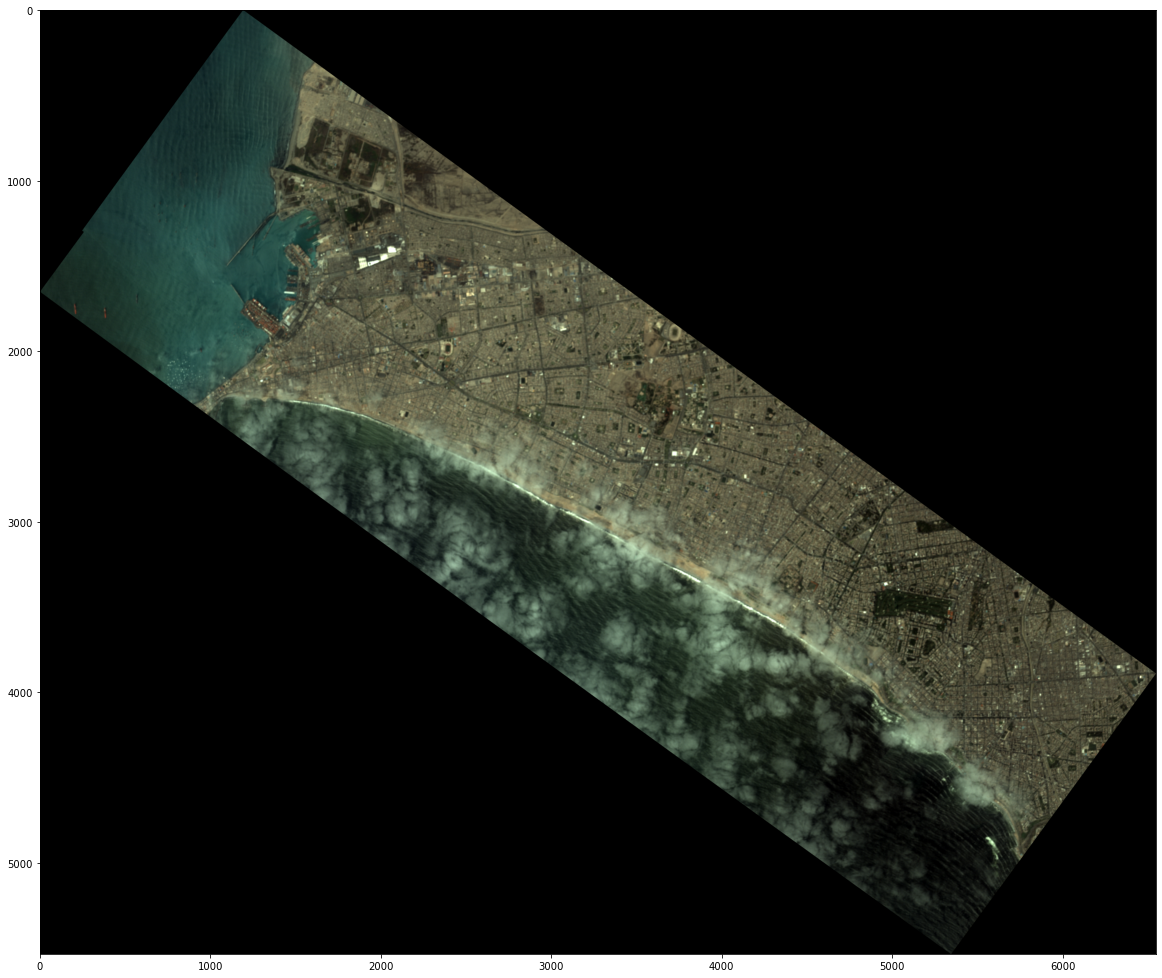

In [128]:
im = Image.fromarray(img)
img_array = np.array(im)

plt.figure(figsize=(20,20))
plt.imshow(img_array)

In [22]:
img.shape

(5534, 6546, 3)

In [32]:
# Pad Target Image
z_pad = np.zeros((300,300,3), dtype=np.uint8)

# Get coordinates
x_start = int((z_pad.shape[0] - img_cropped.shape[0]) / 2)
x_end = x_start + img_cropped.shape[0]
y_start = int((z_pad.shape[1] - img_cropped.shape[1]) / 2)
y_end = y_start + img_cropped.shape[1]
z_pad[x_start:x_end, y_start:y_end, :] = img_cropped

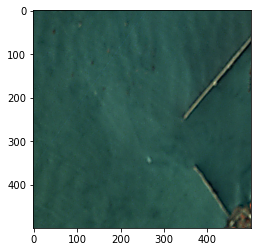

In [14]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# with PIL
im = Image.fromarray(img[1250:1750,750:1250,:])
im2 = im.filter(ImageFilter.UnsharpMask(radius=3.0, percent=300))

img_array = np.array(im)
img_cropped_2 = np.array(im2)

plt.imshow(img_cropped_2)

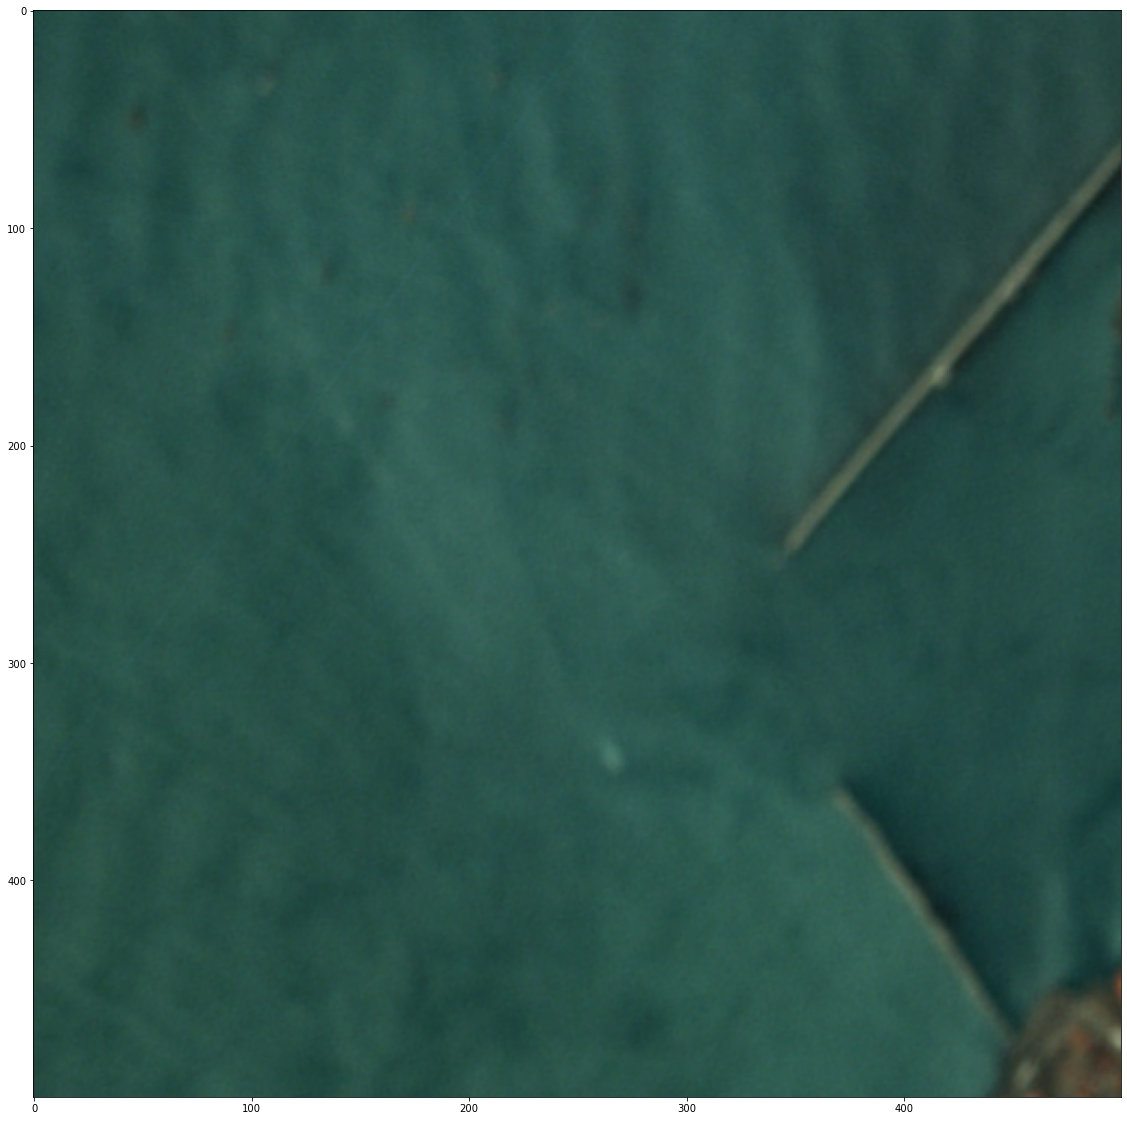

In [52]:
plt.figure(figsize=(20,20))
plt.imshow(img_array)

## Get Predictions

In [129]:
from torchvision.transforms import functional as F
img_crop = img

image = F.to_tensor(img_crop)
model.eval()
with torch.no_grad():
    #prediction = model([img_torch.to(device)])
    prediction = model([(image).to(device)])

In [130]:
prediction[0]

{'boxes': tensor([[1182.4152, 1688.7997, 1424.0927, 1927.7963],
         [1423.8489, 1646.1493, 1509.5796, 1692.3026],
         [1407.5776, 1737.5275, 1504.1825, 1852.6047],
         [1425.6381, 1628.4227, 1507.4025, 1678.2715],
         [1386.7705, 1750.1038, 1515.8754, 1903.1143],
         [1409.0228, 1784.1876, 1477.3541, 1878.7194]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9836, 0.7405, 0.7036, 0.2347, 0.0806, 0.0747], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,

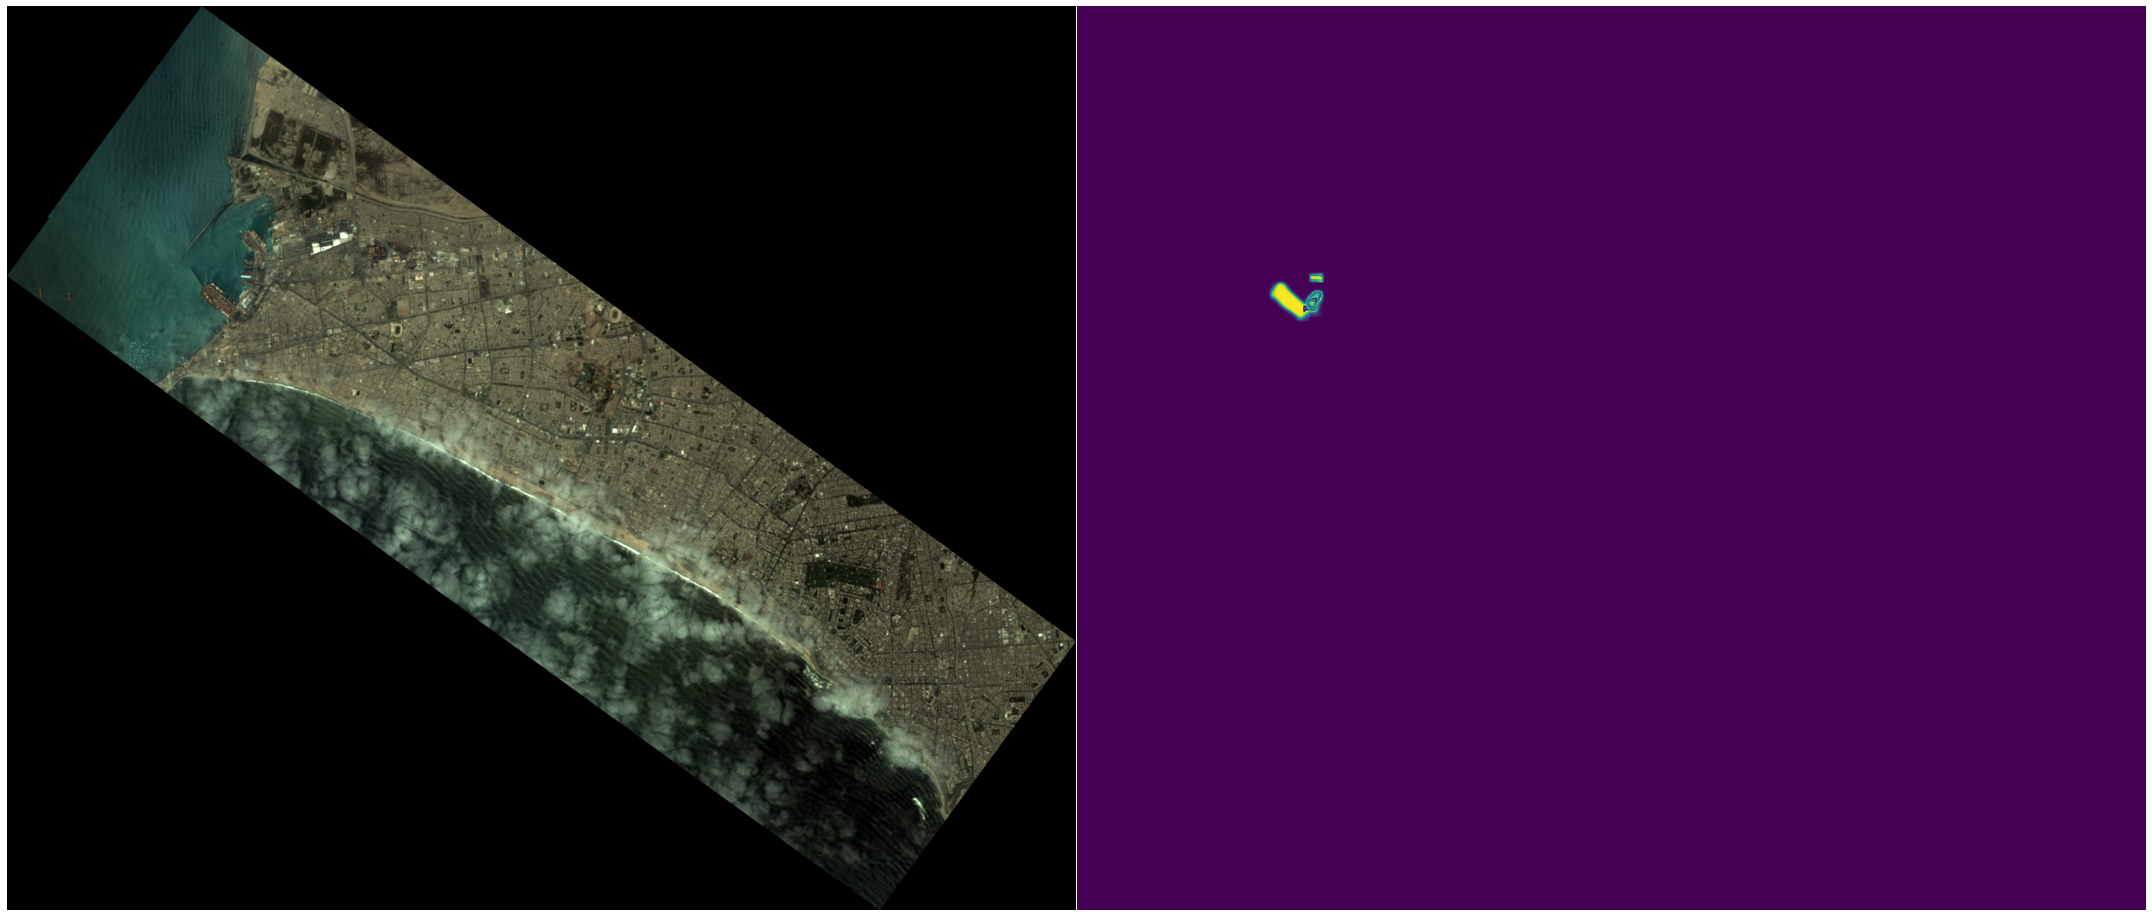

In [131]:
import matplotlib.pyplot as plt
from PIL import Image


#img = Image.fromarray(np.array((img_array[0, :, :, None]), dtype=int))

n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.00)])

masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for mask in prediction[0]['masks'][1:n_pos, 0]:
    masks += mask.mul(255).byte().cpu().numpy()

fig, axarr = plt.subplots(1, 2, figsize=(30, 80))
axarr[0].axis('off')
axarr[1].axis('off')
#axarr[2].axis('off')
#axarr[3].axis('off')
axarr[0].imshow(Image.fromarray(img_crop))#, cmap='Blues')
axarr[1].imshow(Image.fromarray(masks))
#axarr[2].imshow(img)
#axarr[2].imshow(all_masks, alpha=0.4)
#axarr[3].imshow(first_mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [53]:
from torchvision.transforms import functional as F
img_crop = img_array

image = F.to_tensor(img_crop)
model.eval()
with torch.no_grad():
    #prediction = model([img_torch.to(device)])
    prediction = model([(image).to(device)])

In [54]:
prediction[0]

{'boxes': tensor([[409.3790, 499.9644, 416.0274, 500.0000],
         [499.9145,   0.0000, 500.0000,   1.2204],
         [390.2174, 499.9879, 396.0258, 500.0000],
         [499.9756,  17.5950, 500.0000,  22.6771]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.1381, 0.1381, 0.1381, 0.1381], device='cuda:0'),
 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3230],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3409],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...

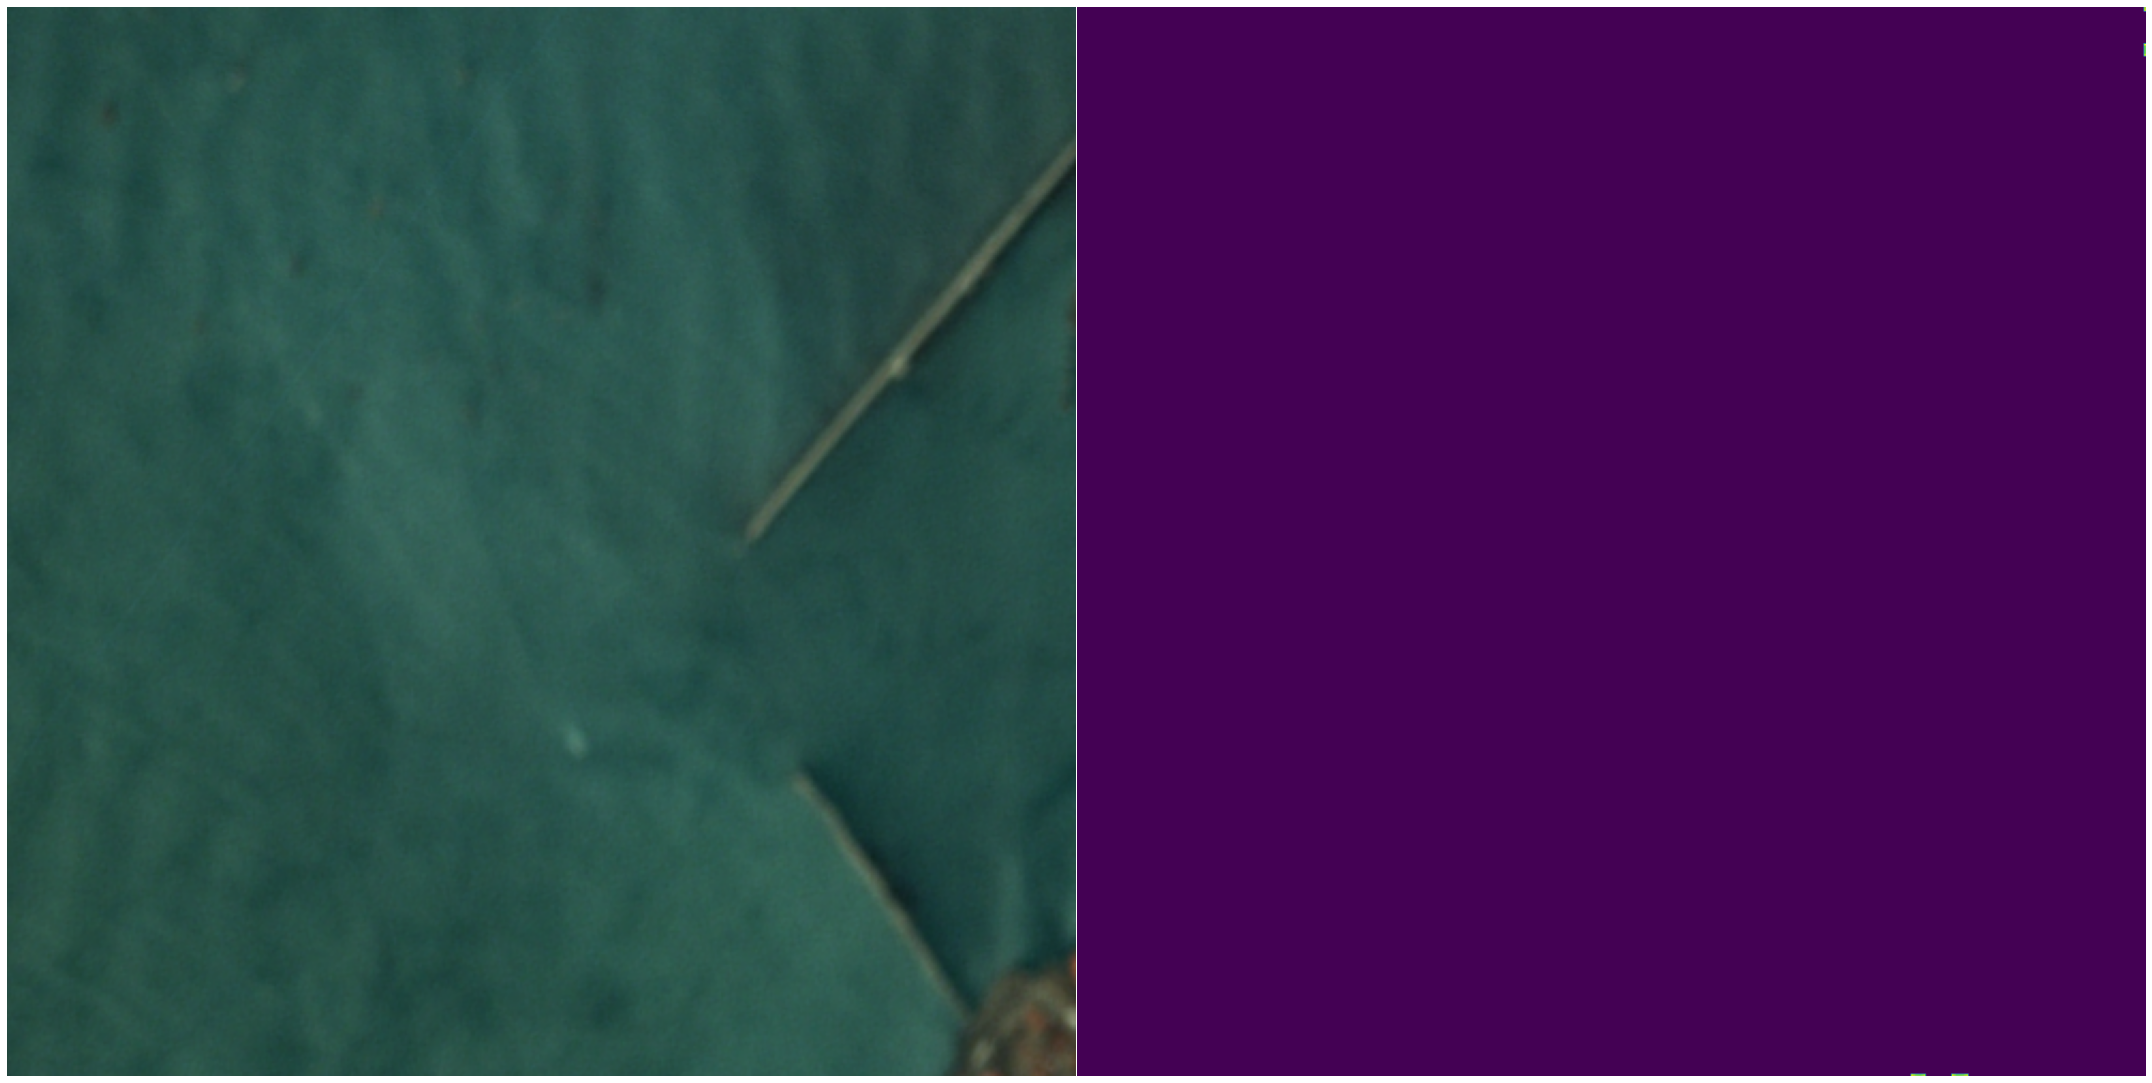

In [55]:
import matplotlib.pyplot as plt
from PIL import Image


#img = Image.fromarray(np.array((img_array[0, :, :, None]), dtype=int))

n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.00)])

masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for mask in prediction[0]['masks'][1:n_pos, 0]:
    masks += mask.mul(255).byte().cpu().numpy()

fig, axarr = plt.subplots(1, 2, figsize=(30, 80))
axarr[0].axis('off')
axarr[1].axis('off')
#axarr[2].axis('off')
#axarr[3].axis('off')
axarr[0].imshow(Image.fromarray(img_crop))#, cmap='Blues')
axarr[1].imshow(Image.fromarray(masks))
#axarr[2].imshow(img)
#axarr[2].imshow(all_masks, alpha=0.4)
#axarr[3].imshow(first_mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [185]:
from torchvision.transforms import functional as F
img_crop = img[1250:2000,:1250,:]

image = F.to_tensor(img_crop)
model.eval()
with torch.no_grad():
    #prediction = model([img_torch.to(device)])
    prediction = model([(image).to(device)])

In [186]:
prediction[0]

{'boxes': tensor([[373.3688, 496.1998, 389.8733, 557.8862],
         [196.7849, 472.4313, 215.7555, 534.3055],
         [559.6682, 418.6630, 574.2795, 467.1904]], device='cuda:0'),
 'labels': tensor([1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9915, 0.9224, 0.1782], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

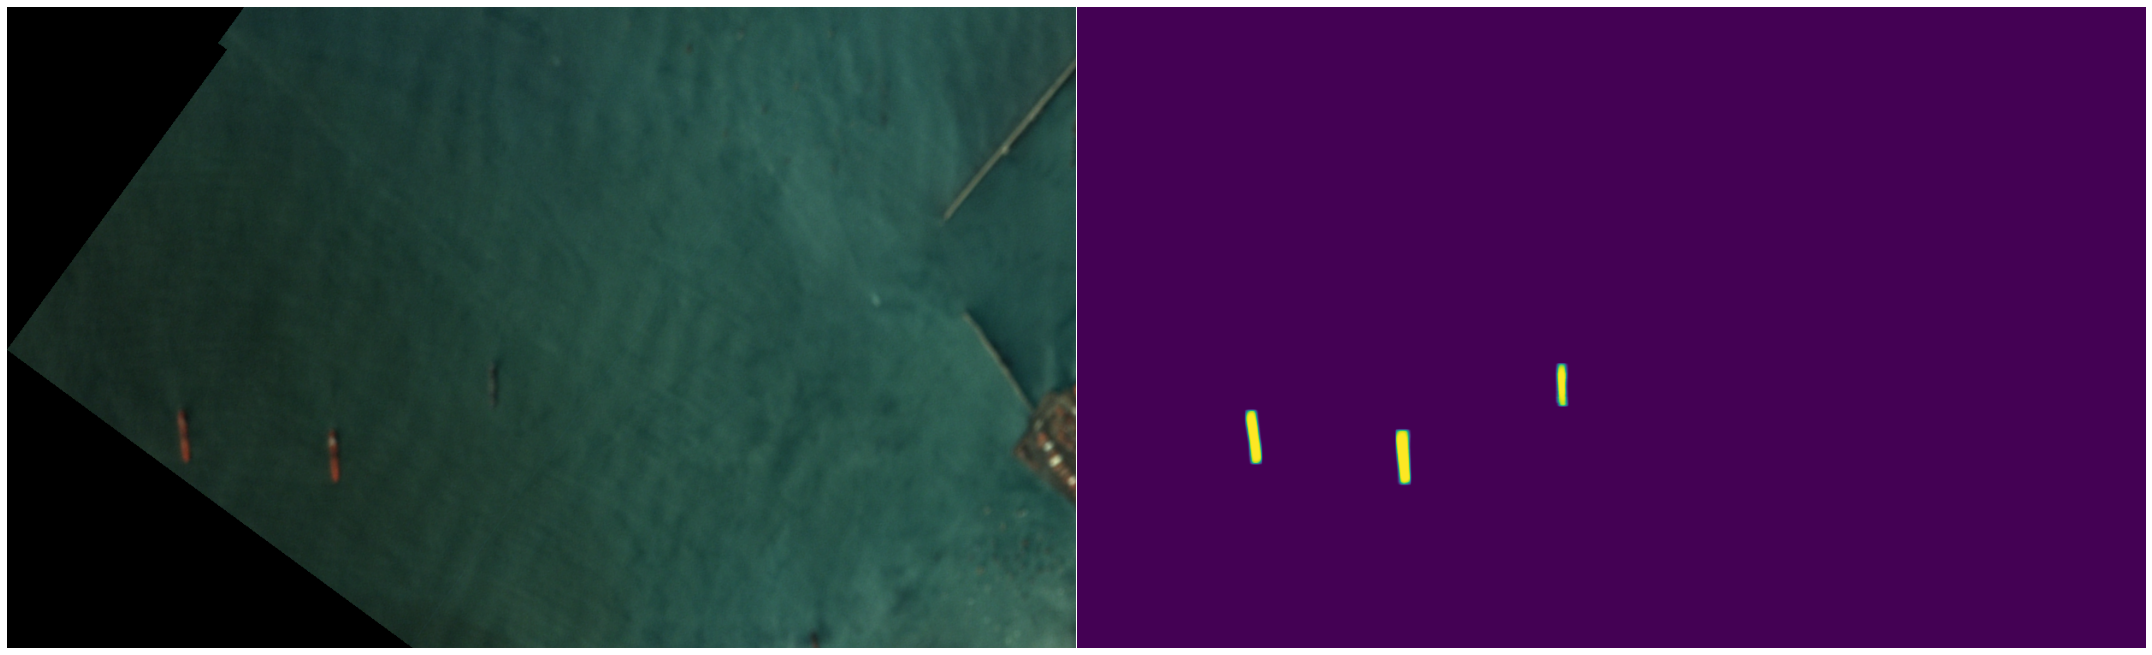

In [57]:
import matplotlib.pyplot as plt
from PIL import Image


#img = Image.fromarray(np.array((img_array[0, :, :, None]), dtype=int))

n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.00)])

masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for mask in prediction[0]['masks'][1:n_pos, 0]:
    masks += mask.mul(255).byte().cpu().numpy()

fig, axarr = plt.subplots(1, 2, figsize=(30, 80))
axarr[0].axis('off')
axarr[1].axis('off')
#axarr[2].axis('off')
#axarr[3].axis('off')
axarr[0].imshow(Image.fromarray(img_crop))#, cmap='Blues')
axarr[1].imshow(Image.fromarray(masks))
#axarr[2].imshow(img)
#axarr[2].imshow(all_masks, alpha=0.4)
#axarr[3].imshow(first_mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

# Postprocessor

The structure of the dataframe should be something like:

- target_id (item_id + _target_number_)
- item_id (index)
- datetime (Datetime.Datetime)
- probability
- lat (center of box)
- long (center of box)
- bbox (measured within image)
- area
- major axis length in meters
- minor axis length in meters

In [181]:
def make_df():
    col_names = ['target_id', 'item_id', 'datetime', 'probability', 'latitude', 'longitude',
                'bounding_box', 'area', 'major_length', 'minor_length']
    df = pd.DataFrame(columns=col_names)
    df.set_index('target_id')
    return df

In [11]:
import pandas as pd


df = make_df()
df.columns

Index(['target_id', 'item_id', 'datetime', 'probability', 'latitude',
       'longitude', 'bounding_box', 'area', 'major_length', 'minor_length'],
      dtype='object')

In [18]:
df.loc[2] = {'target_id':3, 'item_id':1, 'datetime':2, 'probability':3, 'latitude':4, 'longitude':5,
                'bounding_box':6, 'area':7, 'major_length':8, 'minor_length':9}
df.head()

target_id item_id datetime probability latitude longitude bounding_box area  \
0         0       1        2           3        4         5            6    7   
1         1       1        2           3        4         5            6    7   
2         3       1        2           3        4         5            6    7   

  major_length minor_length  
0            8            9  
1            8            9  
2            8            9

In [20]:
def get_datetime(item_id):
    datetime_str = item_id[:15]
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    return datetime_obj

In [23]:
from datetime import datetime


item_id = r'20200530_140109_0f36'
datetime_str = get_datetime(item_id)
str(datetime_str)

'2020-05-30 14:01:09'

In [141]:
def get_bboxes(prediction, thresh=0.5):
    '''Selects only those bounding boxes associated with 
    probabilities greater than threshold.
    '''
    scores =  prediction['scores'].cpu().numpy()
    filtered_idx = np.where(scores > thresh)
    bboxes = prediction['boxes'].cpu().numpy()
    bboxes = bboxes[filtered_idx]
    return list(zip(scores[filtered_idx], bboxes))

In [142]:
for score in prediction[0]['scores'].cpu().numpy():
    print(score)
scores =  prediction[0]['scores'].cpu().numpy()
#scores[score > 0.09]
filtered_idx = np.where(scores > 0.5)
bboxes = prediction[0]['boxes'].cpu().numpy()
bboxes[filtered_idx]

0.9835639
0.740523
0.7035507
0.2346761
0.08059738
0.07471908


array([[1182.4152, 1688.7997, 1424.0927, 1927.7963],
       [1423.8489, 1646.1493, 1509.5796, 1692.3026],
       [1407.5776, 1737.5275, 1504.1825, 1852.6047]], dtype=float32)

In [143]:
for score, bbox in zip(scores[filtered_idx], bboxes):
    print(score)
    print(bbox)

0.9835639
[1182.4152 1688.7997 1424.0927 1927.7963]
0.740523
[1423.8489 1646.1493 1509.5796 1692.3026]
0.7035507
[1407.5776 1737.5275 1504.1825 1852.6047]


In [144]:
for score, bbox in get_bboxes(prediction[0], 0.0):
    print(score, bbox)

0.9835639 [1182.4152 1688.7997 1424.0927 1927.7963]
0.740523 [1423.8489 1646.1493 1509.5796 1692.3026]
0.7035507 [1407.5776 1737.5275 1504.1825 1852.6047]
0.2346761 [1425.6381 1628.4227 1507.4025 1678.2715]
0.08059738 [1386.7705 1750.1038 1515.8754 1903.1143]
0.07471908 [1409.0228 1784.1876 1477.3541 1878.7194]


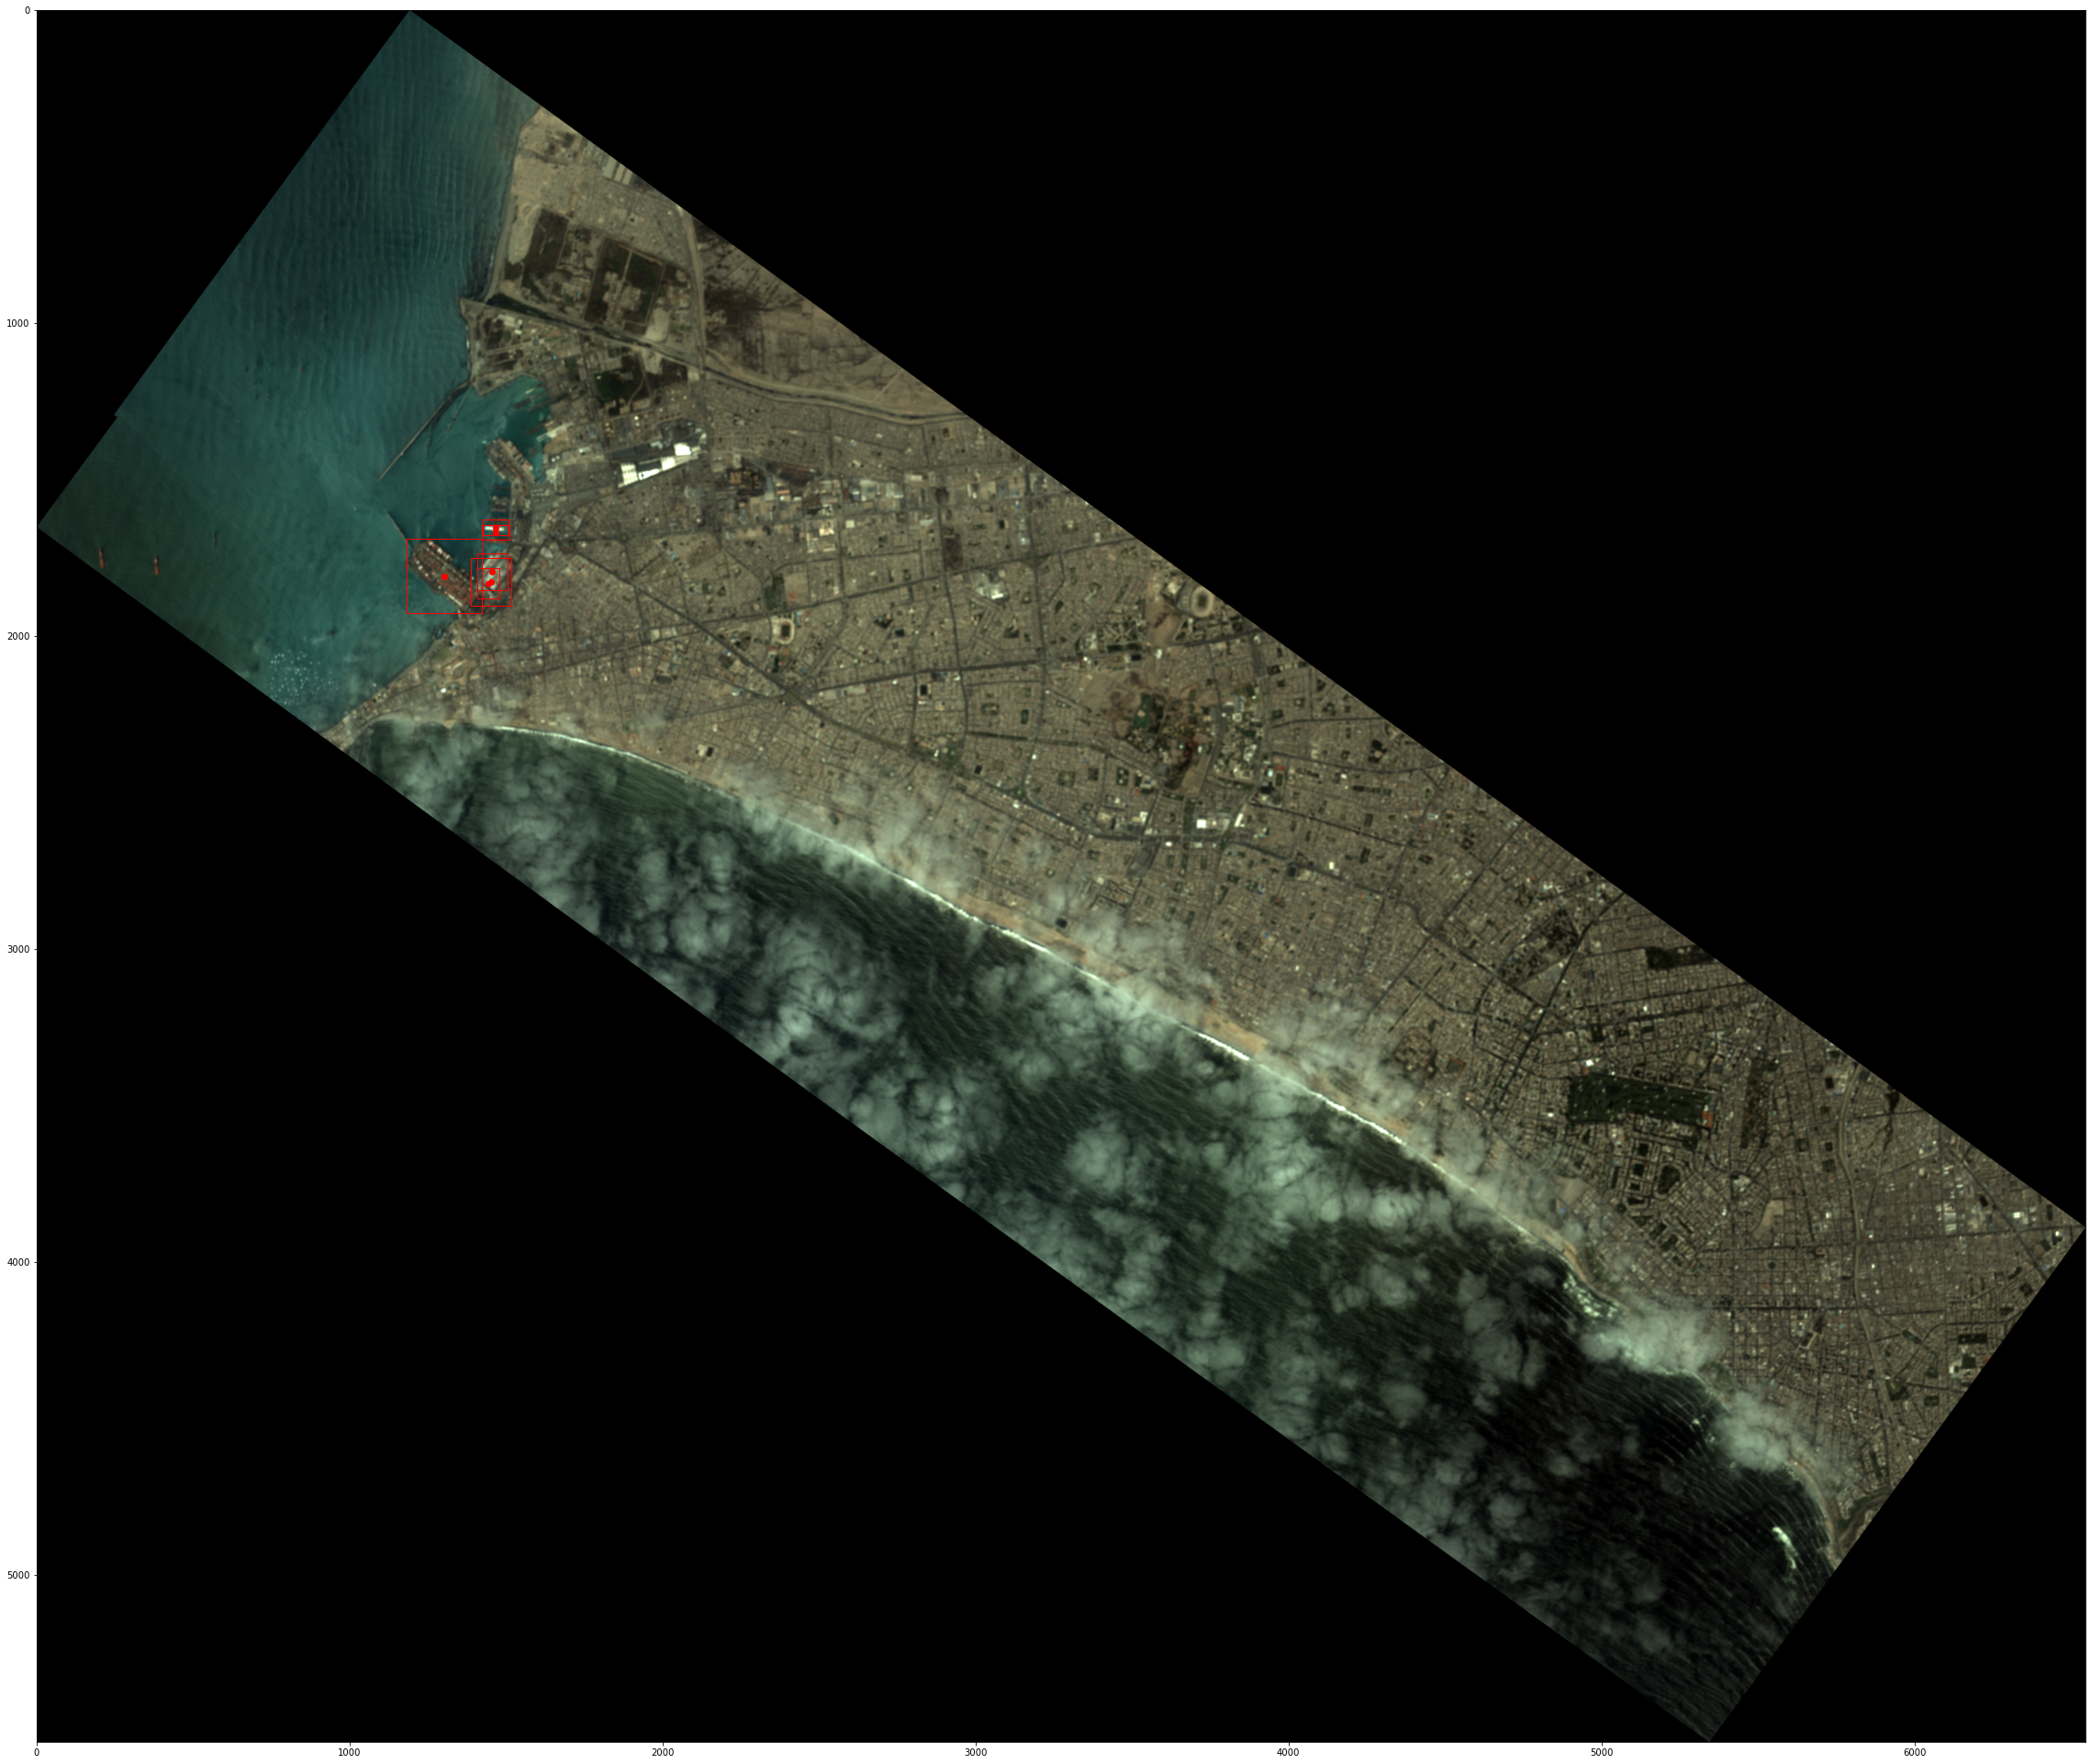

In [145]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = img_crop

# Create figure and axes
fig,ax = plt.subplots(1, figsize=(40,40))

# Display the image
ax.imshow(im)

for _, bbox in get_bboxes(prediction[0], 0.0):
    x0, y0, x1, y1 = bbox
    
    center_x = x0 + ((x1 - x0) / 2)
    center_y = y0 + ((y1 - y0) / 2)
    # Create a Rectangle patch
    rect = patches.Rectangle((x0, y0), x1-x0, y1-y0,linewidth=1,edgecolor='r',facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.scatter(center_x, center_y,color='r')

plt.show()

In [146]:
from osgeo import gdal, osr


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        

        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return list(zip(results, lat_long_list))

In [27]:
from osgeo import gdal, osr
filepath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'

# Open image with gdal
ds = gdal.Open(filepath)
xoff, a, b, yoff, d, e = ds.GetGeoTransform()

# Get projection information from source image
ds_proj = ds.GetProjectionRef()
ds_srs = osr.SpatialReference(ds_proj)

# Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
geogcs = ds_srs.CloneGeogCS()

# Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
transform = osr.CoordinateTransformation(ds_srs, geogcs)

y = 6546
x = 0

# Get global coordinates from pixel x, y coords
projected_x = a * y + b * x + xoff
projected_y = d * y + e * x + yoff

# Transform from projected x, y to geographic lat, lng
(lat, lng, elev) = transform.TransformPoint(projected_x, projected_y)

In [75]:
prediction[0]

{'boxes': tensor([[373.3688, 496.1998, 389.8733, 557.8862],
         [196.7849, 472.4313, 215.7555, 534.3055],
         [559.6682, 418.6630, 574.2795, 467.1904]], device='cuda:0'),
 'labels': tensor([1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9915, 0.9224, 0.1782], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

In [77]:
list(results)

[]

In [161]:
img_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        

        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return lat_long_list

results = get_bboxes(prediction[0], 0.0)
rows = list(zip(results, convert_px_to_lat_long(results, img_path)))

In [163]:
rows[0][0][0]

0.9835639

In [134]:
print(list(get_bboxes(prediction[0], 0.0)))

[(0.9835639, array([1182.4152, 1688.7997, 1424.0927, 1927.7963], dtype=float32)), (0.740523, array([1423.8489, 1646.1493, 1509.5796, 1692.3026], dtype=float32)), (0.7035507, array([1407.5776, 1737.5275, 1504.1825, 1852.6047], dtype=float32)), (0.2346761, array([1425.6381, 1628.4227, 1507.4025, 1678.2715], dtype=float32)), (0.08059738, array([1386.7705, 1750.1038, 1515.8754, 1903.1143], dtype=float32)), (0.07471908, array([1409.0228, 1784.1876, 1477.3541, 1878.7194], dtype=float32))]


In [139]:
results = get_bboxes(prediction[0], 0.0)
row = zip((results), convert_px_to_lat_long(results, img_path))
print(list(row))

[]


In [26]:
elev

0.0

In [ ]:
from osgeo import gdal, osr


img = skimage.io.imread(img_path_4)

# Open image with gdal
ds = gdal.Open(filepath)
xoff, a, b, yoff, d, e = ds.GetGeoTransform()

# Get projection information from source image
ds_proj = ds.GetProjectionRef()
ds_srs = osr.SpatialReference(ds_proj)

# Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
geogcs = ds_srs.CloneGeogCS()

# Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
transform = osr.CoordinateTransformation(ds_srs, geogcs)

# Convert multi-channel image it into red, green and blueb[, alpha] channels 
red, green, blue, nir = numpy.rollaxis(numpy.array(img), axis=-1)

In [ ]:
# Mask: threshold + stops canny detecting image boundary edges
#average_intensity = np.average(target_image)
#mask = target_image > average_intensity

# Create mask for edge detection
#skimage.io.imsave('output/mask.png', mask * 255)

# Prepare result structure
result = {
    "ship_count": 0,
    "ships": []
}

outpath = 'output/'
if not os.path.exists(os.path.dirname(outpath)):
    try:
        os.makedirs(os.path.dirname(outpath))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
# Use Felzenszwalb algo to find segements
#segments_fz = felzenszwalb(mask, scale=0.1, multichannel=False)

# Build labeled mask to show where ships were dectected
#segmented_img = mark_boundaries(mask, segments_fz)
#skimage.io.imsave('output/mask_labeled.png', segmented_img)

# Count ships and save image of each boat clipped from masked image
for idx, blob in enumerate(blobs_log):
    
    # If area matches that of a stanard ship, count it
    #if (ship.area >= 300 and ship.area <= 10000):
        
    # Incrment count
    result['ship_count'] += 1

    # Create ship thumbnail
    x, y, r = blob

    # Get global coordinates from pixel x, y coords
    projected_x = a * y + b * x + xoff
    projected_y = d * y + e * x + yoff
    
    # Transform from projected x, y to geographic lat, lng
    (lat, lng, elev) = transform.TransformPoint(projected_x, projected_y)
    
    # Add ship to results cluster
    result["ships"].append({
        "id": idx + 1,
        "lat": lat,
        "lng": lng,
        "size": r
    })

# Display results
print(json.dumps(result, indent=2))

#Display mask used for ship detection.
#display(Image(filename='output/mask.png'))

# Display labled mask where we detected ships
#display(Image(filename='output/mask_labeled.png'))

In [173]:
target = rows[1]
target

((0.740523,
  array([1423.8489, 1646.1493, 1509.5796, 1692.3026], dtype=float32)),
 (-12.04562790235943, -77.13975518580779))

In [174]:
x0, y0, x1, y1 = target[0][1]
m_per_pix = 3.0

diff_y = (y1 - y0) * m_per_pix
diff_x = (x1 - x0) * m_per_pix
area = diff_y * diff_x
major_length = max(diff_y, diff_x)
minor_length = min(diff_y, diff_x)
print(area, major_length, minor_length)

35610.813473939896 257.192138671875 138.4599609375


In [179]:
def add_results(rows, datetime, item_id, df, m_per_pix=3.0):
    for idx, target in enumerate(rows):
        target_id = item_id + '_'  + str(idx)
        probability = target[0][0]
        latitude = target[1][0]
        longitude = target[1][1]

        bounding_box = target[0][1]
        x0, y0, x1, y1 = bounding_box
        diff_y = (y1 - y0) * m_per_pix
        diff_x = (x1 - x0) * m_per_pix
        area = diff_y * diff_x
        major_length = max(diff_y, diff_x)
        minor_length = min(diff_y, diff_x)

        df.append({'target_id':target_id, 'item_id':item_id, 'datetime':datetime, 
                   'probability':probability, 'latitude':latitude, 'longitude':longitude, 
                   'bounding_box':bounding_box, 'area':area, 'major_length':major_length, 
                   'minor_length':minor_length})

In [180]:
def process_outputs(df, prediction, item_id, img_path, thresh=0.5, m_per_pix=3.0):
    if prediction['scores'].cpu().numpy().shape[0] < 1:
        return
    datetime = get_datetime(item_id)    
    results = get_bboxes(prediction[0], thresh)
    rows = list(zip(results, convert_px_to_lat_long(results, img_path)))
    add_results(rows, datetime, df, m_per_pix=m_per_pix)

In [218]:
import pandas as pd

from datetime import datetime
from osgeo import gdal, osr


def make_df():
    col_names = ['target_id', 'item_id', 'datetime', 'probability', 'latitude', 'longitude',
                'bounding_box', 'area', 'major_length', 'minor_length']
    df = pd.DataFrame(columns=col_names)
    df.set_index('target_id')
    return df


def get_datetime(item_id):
    datetime_str = item_id[:15]
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    return datetime_obj


def get_bboxes(prediction, thresh=0.5):
    '''Selects only those bounding boxes associated with 
    probabilities greater than threshold.
    '''
    scores =  prediction['scores'].cpu().numpy()
    filtered_idx = np.where(scores > thresh)
    bboxes = prediction['boxes'].cpu().numpy()
    bboxes = bboxes[filtered_idx]
    return list(zip(scores[filtered_idx], bboxes))


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        

        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return list(zip(results, lat_long_list))


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        
        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return lat_long_list


def add_results(rows, datetime, item_id, df, m_per_pix=3.0):
    row_list = []
    for idx, target in enumerate(rows):
        target_id = item_id + '_'  + str(idx)
        probability = target[0][0]
        latitude = target[1][0]
        longitude = target[1][1]

        bounding_box = target[0][1]
        x0, y0, x1, y1 = bounding_box
        diff_y = (y1 - y0) * m_per_pix
        diff_x = (x1 - x0) * m_per_pix
        area = diff_y * diff_x
        major_length = max(diff_y, diff_x)
        minor_length = min(diff_y, diff_x)

        row_list.append({'target_id':target_id, 'item_id':item_id, 'datetime':datetime, 
                   'probability':probability, 'latitude':latitude, 'longitude':longitude, 
                   'bounding_box':bounding_box, 'area':area, 'major_length':major_length, 
                   'minor_length':minor_length}) #ignore_index=True)
    df = df.append(row_list)
    return df
        
        
def process_outputs(prediction, item_id, img_path, df=None, thresh=0.5, m_per_pix=3.0):
    if prediction[0]['scores'].cpu().numpy().shape[0] < 1:
        return
    if df is None:
        df = make_df()
    datetime = get_datetime(item_id)    
    results = get_bboxes(prediction[0], thresh)
    rows = list(zip(results, convert_px_to_lat_long(results, img_path)))
    df = add_results(rows, datetime, item_id, df, m_per_pix=m_per_pix)
    return df
    

if __name__ == '__main__':
    df = make_df()
    prediction = prediction
    item_id = r'20161204_181909_0d06'
    img_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
    df = process_outputs(prediction, item_id, img_path, df, thresh=0.5, m_per_pix=3.0)

In [217]:
df.head()

target_id               item_id            datetime  \
0  20161204_181909_0d06_0  20161204_181909_0d06 2016-12-04 18:19:09   
1  20161204_181909_0d06_1  20161204_181909_0d06 2016-12-04 18:19:09   

   probability   latitude  longitude  \
0     0.991542 -12.015967 -77.170979   
1     0.922434 -12.011208 -77.171593   

                                 bounding_box  area  major_length  \
0  [373.3688, 496.19977, 389.8733, 557.88617]   0.0           0.0   
1  [196.78487, 472.4313, 215.75552, 534.3055]   0.0           0.0   

   minor_length  
0           0.0  
1           0.0

In [213]:
rows

[((0.99154246,
   array([373.3688 , 496.19977, 389.8733 , 557.88617], dtype=float32)),
  (-12.015967253074233, -77.17097882802683)),
 ((0.92243356,
   array([196.78487, 472.4313 , 215.75552, 534.3055 ], dtype=float32)),
  (-12.011208332462274, -77.17159271640601)),
 ((0.17817187,
   array([559.66815, 418.663  , 574.27954, 467.19037], dtype=float32)),
  (-12.02097425109299, -77.17333575090989))]